<a href="https://colab.research.google.com/github/KU-BIG/KUBIG_2023_FALL/blob/main/4.%20KUBIG%20CONTEST%20/%20DL(%EC%9E%84%EC%84%B1%EB%B9%88%EA%B5%90%EC%88%98%EB%8B%98)%20/%20Trial_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study

### Import Library

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.models as models # 일부 pretrained model을 포함한 다양한 딥러닝 모델들이 저장됨
from torchvision.transforms import transforms as T
import pandas as pd
import time
from tqdm import tqdm
from PIL import Image # Bytes 로 압축된 이미지를 이미지로 변환하기 위해 필요
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
#import wandb # 로컬 환경에서 활용

## Load Dataset

In [2]:
!git clone https://github.com/sungbinlim/KU-pytorch-study-2023.git

Cloning into 'KU-pytorch-study-2023'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 154 (delta 67), reused 92 (delta 60), pack-reused 53
Receiving objects: 100% (154/154), 60.06 MiB | 1011.00 KiB/s, done.
Resolving deltas: 100% (89/89), done.


In [3]:
!unzip ../content/KU-pytorch-study-2023/ion_data/train.zip -d ../content/KU-pytorch-study-2023/ion_data/
!unzip ../content/KU-pytorch-study-2023/ion_data/valid.zip -d ../content/KU-pytorch-study-2023/ion_data/
!rm -r -f ../content/KU-pytorch-study-2023/ion_data/__MACOSX/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_300.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/__MACOSX/valid/._image_300.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_3804.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/__MACOSX/valid/._image_3804.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_6099.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/__MACOSX/valid/._image_6099.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_7387.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/__MACOSX/valid/._image_7387.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_5590.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/__MACOSX/valid/._image_5590.png  
  inflating: ../content/KU-pytorch-study-2023/ion_data/valid/image_4856.png  
  inflating: ../content/KU-pytorch-study-2023/ion_dat

## EDA

In [4]:
train = pd.read_pickle('/content/KU-pytorch-study-2023/ion_data/train.pkl')
train.head()

,n,potential,position,img_path
0,5,0.226,"[81, 117, 150, 182, 218]",train/image_0.png
1,7,0.448,"[93, 114, 132, 150, 167, 185, 206]",train/image_1.png
2,5,0.341,"[97, 125, 150, 174, 202]",train/image_2.png
3,8,0.390,"[82, 104, 123, 141, 158, 176, 195, 217]",train/image_3.png
4,8,0.404,"[83, 105, 124, 141, 158, 175, 194, 216]",train/image_4.png


<Axes: xlabel='n'>

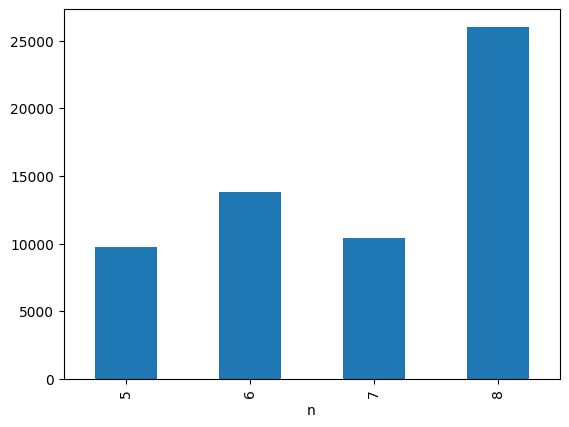

In [5]:
train.groupby(['n']).potential.count().plot.bar()

In [6]:
train['position_mean'] = train['position'].apply(lambda x: np.mean(x))
train['position_std'] = train['position'].apply(lambda x: np.std(x))

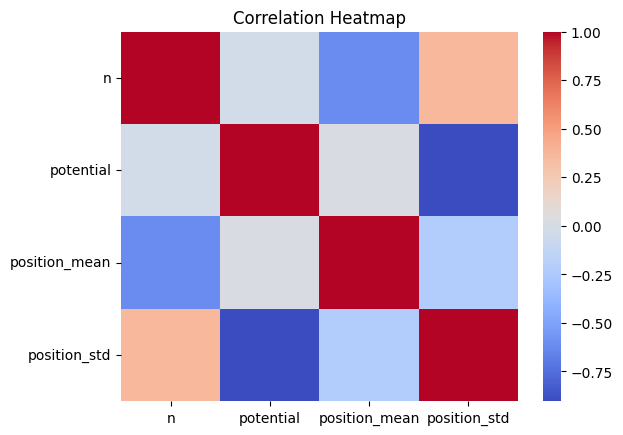

In [7]:
corr = train.corr()
ax = sns.heatmap(corr, cmap = 'coolwarm')
ax.set_title("Correlation Heatmap")
plt.show()

In [8]:
train.corr() # -0.9

,n,potential,position_mean,position_std
n,1.000000,-0.032705,-0.618925,0.365196
potential,-0.032705,1.000000,0.011843,-0.903485
position_mean,-0.618925,0.011843,1.000000,-0.224642
position_std,0.365196,-0.903485,-0.224642,1.000000


In [9]:
train['position_var'] = train['position'].apply(lambda x : np.var(x))

<Axes: xlabel='position_var', ylabel='potential'>

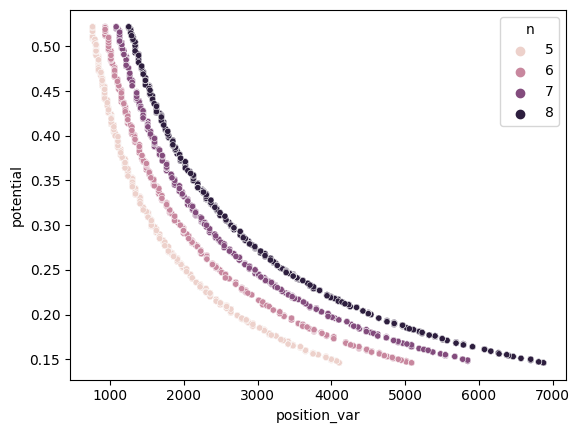

In [10]:
sns.scatterplot(data=train, x='position_var', y='potential', hue='n', s=20)

<Axes: xlabel='position_std', ylabel='potential'>

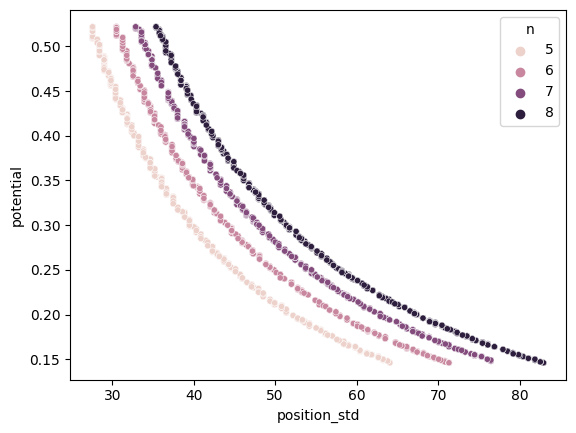

In [11]:
sns.scatterplot(data=train, x='position_std', y='potential', hue='n', s=20)

### Domain knowledge

<img src = "https://drive.google.com/uc?id=1rxyBZxde5go5a9RQhdo8vm6BI9aKukLy" height = 70 width = 210> \
교수님 말씀대로 이온 트랩 방식의 양자컴퓨터에서 이온의 퍼텐션 값은 이온 포지션의 분산과 연관되어 있다.

---

이온의 포지션을 예측한다면 그 길이로 이온의 개수를, 관계식으로 퍼텐셜 에너지를 산출할 수 있다. \
Classifier 와 Regressor 동시 학습은 난이도가 높기 때문에, 포지션을 우선적으로 예측한 후 나머지 값들을 구하고자 한다. \
따라서 이온의 포지션을 예측하기 위해 5~8개의 가변 입력값을 가질 수 있는 RNN 계열 모델을 사용하고자 한다.

## Custom Dataset

In [12]:
class IonDataset(Dataset):
    def __init__(self, data_dir, mode='train', img_size=(10, 300), n=None):
        self.df = pd.read_pickle(os.path.join(data_dir, f"{mode}.pkl"))

        if n is not None:  # to extract a specific n
            self.df = self.df[self.df["n"] == n]

        self.data_dir = data_dir
        self.image_path = self.df["img_path"].values

        self.min_a2 = 0.146
        self.max_a2 = 0.522

        self.df["norm_potential"] = self.df["potential"].apply(lambda p : (p - self.min_a2)/ (self.max_a2 - self.min_a2))  # min-max normalization

        self.n = self.df["n"].values
        self.max_n = self.n.max()
        self.min_n = self.n.min()

        self.potential = self.df["potential"].values.astype('float32')
        self.norm_potential = self.df["norm_potential"].values.astype('float32')
        self.position = self.df["position"].values # array 외의 다른 자료형

        self.h, self.w = img_size
        self.crop_size = (10, self.w)
        self.img_transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            # T.CenterCrop(self.crop_size)
        ])

    def make_one_hot(self, scalar):
        one_hot_dim = self.max_n - self.min_n + 1
        address = scalar - one_hot_dim - 1
        one_hot_vec = np.zeros(one_hot_dim)
        one_hot_vec[address] = 1.0
        return one_hot_vec

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img = Image.open(os.path.join(self.data_dir, self.image_path[idx]))
        img = self.img_transform(img)
        #ion_position = torch.tensor(self.position[idx], dtype = torch.float32)
        ion_number = torch.tensor(self.make_one_hot(self.n[idx]))
        ion_potential = torch.tensor(self.norm_potential[idx])

        return img, ion_number, ion_potential

## Define the Model

In [13]:
class MLP(nn.Module):
    def __init__(self, hidden_variables=[128, 64], input_output_dim=(1, 1)):
        super().__init__()
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()

        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable, dtype=torch.float32))
            self.layer.add_module('activation_' + str(i), nn.ReLU())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim, dtype=torch.float32))

    def forward(self, x):
        y_hat = self.layer(x)
        return y_hat

class IonPredictor(nn.Module):
    def __init__(self, kernel_size=3, num_features=1000):
        super().__init__()

        self.cnn = models.resnet18()
        self.cnn.conv1 = nn.Conv2d(1, 64, kernel_size=kernel_size, stride=2, padding=3, bias=False)
        self.mlp = MLP(input_output_dim=(num_features, 5))

    def forward(self, x):

        z = self.cnn(x)
        z.view(z.size(0), -1)
        predict = self.mlp(z)
        return predict[:, :4], predict[:, 4]

## Define UDFs

In [14]:
def make_weights(class_vector):
    classes, class_counts = np.unique(class_vector, return_counts=True)  # class 및 class 별 개수 계산
    class_weights = 1. / class_counts  # class 별 weight 계산
    weights_dict = dict(zip(classes, class_weights))
    weights = [weights_dict[class_vector[i]] for i in range(len(class_vector))]

    return weights

In [15]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):

        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        return loss.item()
    return train_step_fn

def make_valid_step(model, loss_fn):

    def valid_step_fn(x, y):
        model.eval()
        y_hat = model(x)
        model_prediction = torch.argmax(y_hat[0], axis=1)
        target = torch.argmax(y[0], axis=1)
        correct_cnt = torch.sum(model_prediction == target)
        loss_classifier, loss_regressor = loss_fn(y_hat, y)

        return loss_classifier.item(), loss_regressor.item(), correct_cnt.item(), target, model_prediction
    return valid_step_fn

"""
def make_valid_step(model, loss_fn, verbose=False):

    def valid_step_fn(x, y):
        model.eval()
        y_hat = model(x)
        model_prediction = torch.argmax(y_hat[0], axis=1)
        target = torch.argmax(y[0], axis=1)
        correct_cnt = torch.sum(model_prediction == target)
        loss_classifier, loss_regressor = loss_fn(y_hat, y)

        if verbose:
            return loss_classifier.item(), loss_regressor.item(), target, model_prediction
        else:
            return loss_classifier.item(), loss_regressor.item(), correct_cnt.item()
    return valid_step_fn
"""

def draw_confusion_matrix(label_list, pred_list):
    num_classes = 4
    classes = ['5', '6', '7', '8']

    label_list = np.concatenate(label_list)
    pred_list = np.concatenate(pred_list)

    confusion_matrix = metrics.confusion_matrix(label_list, pred_list, labels=[i for i in range(num_classes)])
    confusion_matrix = np.round(confusion_matrix / len(label_list), 2)

    total_correct = np.sum(pred_list == label_list)
    accuracy = np.round(total_correct / len(pred_list) * 100, 3)

    # Create confusion matrix plot
    img = sns.heatmap(confusion_matrix,
                      annot=True,
                      cmap='Blues',
                      xticklabels=classes,
                      yticklabels=classes)

    # Set plot labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix - Accuracy: {accuracy}')
    fig = img.get_figure()
    fig.savefig('test_experiment.png')

    return accuracy

## Training & Validation

In [16]:
num_weights = make_weights(train.n)
weigthed_sampler = WeightedRandomSampler(num_weights, len(num_weights))

In [17]:
# Config file
config = {
        "lr": 0.01,
        "epochs": 50,
        "batch_size": 128,
        "data_dir": '../content/KU-pytorch-study-2023/ion_data',
        "device": 'cuda' if torch.cuda.is_available() else 'cpu',
        "model": IonPredictor,
        "optimizer": optim.SGD,
        "scheduler": optim.lr_scheduler.CosineAnnealingLR,
        "loss_classifier": nn.CrossEntropyLoss,
        "loss_regression": nn.MSELoss,
        }

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

def valid_loss_fn(predict, y):

    ion_number_target, potential_target = y[0], y[1]
    ion_number_predict, potential_predict = predict[0], predict[1]
    return loss_classifier(ion_number_predict, ion_number_target), loss_regression(potential_predict, potential_target)

def train_loss_fn(predict, y):

    ion_number_target, potential_target = y[0], y[1]
    ion_number_predict, potential_predict = predict[0], predict[1]
    loss = loss_classifier(ion_number_predict, ion_number_target) + loss_regression(potential_predict, potential_target)
    return loss

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [19]:
def train_model(train_loader, valid_loader, epochs=100, checkpoint=False, device='cpu'):
    train_losses = []
    valid_losses = []
    early_stopping = EarlyStopping(patience = 3, verbose = True)
    for epoch in range(epochs):

        model.train()
        for x_train_batch, y_train_batch_ion, y_train_batch_potential in train_loader:
            # 데이터 로더에서 받은 미니배치를 device 에 업로드
            x_train_batch = x_train_batch.to(device)
            y_train_batch_ion = y_train_batch_ion.to(device)
            y_train_batch_potential = y_train_batch_potential.to(device)

            # 미니매치 데이터를 이용해 parameter update
            loss = train_step(x_train_batch, [y_train_batch_ion, y_train_batch_potential])

        train_losses.append(loss)
        print("Epoch: {} / Train loss: {}".format(epoch, loss))

        # Evaluate valid loss
        model.eval()
        with torch.no_grad():
            valid_loss, cnt = 0, 0
            label_list = []
            pred_list = []
            for x_valid_batch, y_valid_batch_ion, y_valid_batch_potential in valid_loader:
                # 데이터 로더에서 받은 미니배치를 device 에 업로드
                x_valid_batch = x_valid_batch.to(device)
                y_valid_batch_ion = y_valid_batch_ion.to(device)
                y_valid_batch_potential = y_valid_batch_potential.to(device)

                # 미니매치 데이터를 이용해 performance 평가
                _, eval_valid_loss_regressor, correct_cnt, target, predict = valid_step(x_valid_batch, [y_valid_batch_ion, y_valid_batch_potential])
                cnt += correct_cnt
                valid_loss += eval_valid_loss_regressor * len(x_valid_batch)
            valid_loss = valid_loss / len(valid_data)
            valid_losses.append(valid_loss)
            accuracy = 100 * cnt / len(valid_data)

            print("Epoch: {} / Valid MSE loss: {} / Accuracy {} %".format(epoch, valid_loss, accuracy))

            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                label_list.append(target.cpu().numpy())
                pred_list.append(predict.cpu().numpy())
                accuracy = draw_confusion_matrix(label_list, pred_list)
                checkpoint = {'epochs': epoch,
                              'model_state_dict': model.state_dict(),
                              'optimizer_state_dict': optimizer.state_dict(),
                              'train_loss': train_losses,
                              'valid_loss': valid_losses
                              }

                torch.save(checkpoint, 'model_checkpoint.pth')
                break

    return train_losses, valid_losses

Epoch: 0 / Train loss: 1.1142319739641
Epoch: 0 / Valid MSE loss: 0.023495425578951835 / Accuracy 52.8 %
Validation loss decreased (inf --> 0.023495).  Saving model ...
Epoch: 1 / Train loss: 0.48705291345443885
Epoch: 1 / Valid MSE loss: 0.015992614735662936 / Accuracy 79.02 %
Validation loss decreased (0.023495 --> 0.015993).  Saving model ...
Epoch: 2 / Train loss: 0.1866716761645269
Epoch: 2 / Valid MSE loss: 0.014545946726202965 / Accuracy 93.57 %
Validation loss decreased (0.015993 --> 0.014546).  Saving model ...
Epoch: 3 / Train loss: 0.10654528111134216
Epoch: 3 / Valid MSE loss: 0.010942723743617535 / Accuracy 97.74 %
Validation loss decreased (0.014546 --> 0.010943).  Saving model ...
Epoch: 4 / Train loss: 0.0645589761656898
Epoch: 4 / Valid MSE loss: 0.007988899681717157 / Accuracy 98.94 %
Validation loss decreased (0.010943 --> 0.007989).  Saving model ...
Epoch: 5 / Train loss: 0.027770621397621653
Epoch: 5 / Valid MSE loss: 0.007149204056710005 / Accuracy 98.88 %
Valida

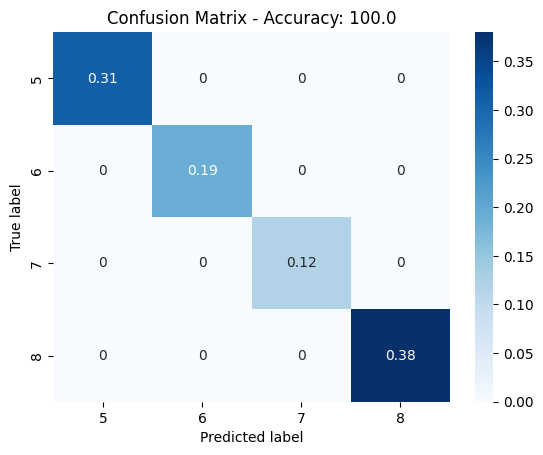

In [20]:
if __name__ == "__main__":

    # Hyperparameters
    data_dir = config['data_dir']
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    device = config['device']
    model = config['model']().to(device)
    optimizer = config['optimizer'](model.parameters(), lr=lr)
    scheduler = config['scheduler'](optimizer, epochs, eta_min=0.)
    loss_classifier = config['loss_classifier']()
    loss_regression = config['loss_regression']()

    # Data setting
    train_data = IonDataset(data_dir, 'train')
    valid_data = IonDataset(data_dir, 'valid')
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    train_step = make_train_step(model, train_loss_fn, optimizer)
    valid_step = make_valid_step(model, valid_loss_fn)
    train_loss, valid_loss = train_model(train_dataloader, valid_dataloader, epochs=epochs, checkpoint=True, device=device)

## Testing

In [ ]:
device = config['device']
data_dir = config['data_dir']
batch_size = 1024
model = config['model']().to(device)
loss_classifier = config['loss_classifier']()
loss_regression = config['loss_regression']()

test_data = IonDataset(data_dir, 'test')
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_step = make_valid_step(model, valid_loss_fn, verbose=True)

with torch.no_grad():
    test_MSE_loss = 0
    label_list = []
    pred_list = []
    for x_test_batch, y_test_batch_ion, y_test_batch_potential in test_dataloader:
        # 데이터 로더에서 받은 미니배치를 device 에 업로드
        x_test_batch = x_test_batch.to(device)
        y_test_batch_ion = y_test_batch_ion.to(device)
        y_test_batch_potential = y_test_batch_potential.to(device)

        # 미니매치 데이터를 이용해 performance 평가
        _, eval_test_loss_regressor, target, predict = test_step(x_test_batch, [y_test_batch_ion, y_test_batch_potential])
        label_list.append(target.cpu().numpy())
        pred_list.append(predict.cpu().numpy())
        test_MSE_loss += eval_test_loss_regressor * batch_size

    test_loss = test_MSE_loss / len(test_data)
    accuracy = draw_confusion_matrix(label_list, pred_list)
    print("Test MSE loss:{}, Accuracy: {}%".format(test_loss, accuracy))

# Project

## 1. img를 통해 ion_position 예측

In [90]:
class IonDataset(Dataset):
    def __init__(self, data_dir, mode='train', img_size=(10, 300), n=None):
        self.df = pd.read_pickle(os.path.join(data_dir, f"{mode}.pkl"))

        if n is not None:  # to extract a specific n
            self.df = self.df[self.df["n"] == n]

        self.data_dir = data_dir
        self.image_path = self.df["img_path"].values
        """
        self.min_a2 = 0.146
        self.max_a2 = 0.522

        self.df["norm_potential"] = self.df["potential"].apply(lambda p: (p - self.min_a2) / (self.max_a2 - self.min_a2))  # min-max normalization

        self.n = self.df["n"].values
        self.max_n = self.n.max()
        self.min_n = self.n.min()

        self.potential = self.df["potential"].values.astype('float32')
        self.norm_potential = self.df["norm_potential"].values.astype('float32')
        #self.position = [pos for pos in self.df["position"].values]
        """
        self.max_pos = 280
        self.min_pos = 19
        self.df['norm_position'] = self.df["position"].apply(lambda pos_list :[(p - self.min_pos) / (self.max_pos - self.min_pos) for p in pos_list])
        self.position = self.df["norm_position"].values

        self.h, self.w = img_size
        self.crop_size = (10, self.w)
        self.img_transform = T.Compose([
            #T.Grayscale(num_output_channels=1)(),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            # T.CenterCrop(self.crop_size)
        ])

    def make_one_hot(self, scalar):
        one_hot_dim = self.max_n - self.min_n + 1
        address = scalar - one_hot_dim - 1
        one_hot_vec = np.zeros(one_hot_dim)
        one_hot_vec[address] = 1.0
        return one_hot_vec

    def padding(self, vector, length):
      t = torch.zeros(length)
      t[:len(vector)] = torch.tensor(vector)
      return t

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_dir, self.image_path[idx]))
        img = self.img_transform(img)
        ion_position = self.padding(self.position[idx], 8)
        ion_position = torch.tensor(ion_position)
        return img, ion_position

In [84]:
class MLP(nn.Module):
    def __init__(self, hidden_variables=[128, 64], input_output_dim=(1, 1)):
        super().__init__()
        self.input_variable_dim = input_output_dim[0]
        self.output_variable_dim = input_output_dim[1]
        self.list_hidden_variable = hidden_variables
        self.layer = nn.Sequential()
        variable_dim = self.input_variable_dim
        for i, hidden_variable in enumerate(self.list_hidden_variable):
            self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable, dtype=torch.float32))
            self.layer.add_module('activation_' + str(i), nn.ReLU())
            variable_dim = hidden_variable
        self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim, dtype=torch.float32))

    def forward(self, x):
        y_hat = self.layer(x)
        return y_hat

class IonPredictor(nn.Module):
    def __init__(self, num_features=1000, num_hidden=128):
        super().__init__()

        self.cnn = models.resnet18()
        self.cnn.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=False)
        self.mlp = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 8)
        )

    def forward(self, x):
        z = self.cnn(x)
        z.view(z.size(0), -1)
        z = self.mlp(z)
        return z

In [85]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):
        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step_fn

def make_valid_step(model, loss_fn):
    def valid_step_fn(x, y):
        model.eval()
        with torch.no_grad():
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
        return loss.item()
    return valid_step_fn

In [76]:
# Config file
config = {
        "lr": 0.0005,
        "epochs": 50,
        "batch_size": 128,
        "data_dir": '../content/KU-pytorch-study-2023/ion_data',
        "device": 'cuda' if torch.cuda.is_available() else 'cpu',
        "model": IonPredictor,
        "optimizer": optim.SGD,
        "scheduler": optim.lr_scheduler.CosineAnnealingLR,
        "loss_classifier": nn.CrossEntropyLoss,
        "loss_regression": nn.MSELoss,
        }

def valid_loss_fn(predict, y):
    ion_position_target = y
    ion_position_predict = predict
    loss = loss_regression(ion_position_predict, ion_position_target)
    return loss

def train_loss_fn(predict, y):
    ion_position_target = y
    ion_position_predict = predict
    loss = loss_regression(ion_position_predict, ion_position_target)
    return loss

In [80]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [95]:
def train_model(train_loader, valid_loader, epochs=100, checkpoint=False, device='cpu'):
    train_losses = []
    valid_losses = []
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        for x_train_batch, y_train_batch_position in train_loader:
            x_train_batch = x_train_batch.to(device)
            y_train_batch_position = y_train_batch_position.to(device)

            loss = train_step(x_train_batch, y_train_batch_position)
        train_losses.append(loss)
        print("Epoch: {} / Train loss: {}".format(epoch, loss))

        # Validation
        model.eval()
        with torch.no_grad():
            valid_loss= 0.0
            for x_valid_batch, y_valid_batch_position in valid_loader:
                x_valid_batch = x_valid_batch.to(device)
                y_valid_batch_position = y_valid_batch_position.to(device)

                loss = valid_step(x_valid_batch, y_valid_batch_position)
                valid_loss += loss
                #valid_loss += loss * len(x_valid_batch)

            avg_valid_loss = valid_loss / len(valid_data)
            valid_losses.append(avg_valid_loss)

            print("Epoch [{}/{}] - Valid Loss: {}".format(epoch+1, epochs, avg_valid_loss))

            early_stopping(avg_valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    return train_losses, valid_losses

In [96]:
if __name__ == "__main__":

    # Hyperparameters
    data_dir = config['data_dir']
    lr = config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    device = config['device']
    model = config['model']().to(device)
    optimizer = config['optimizer'](model.parameters(), lr=lr)
    scheduler = config['scheduler'](optimizer, epochs, eta_min=0.)
    loss_classifier = config['loss_classifier']()
    loss_regression = config['loss_regression']()

    # Data setting
    train_data = IonDataset(data_dir, 'train')
    valid_data = IonDataset(data_dir, 'valid')
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    train_step = make_train_step(model, train_loss_fn, optimizer)
    valid_step = make_valid_step(model, valid_loss_fn)
    train_loss, valid_loss = train_model(train_dataloader, valid_dataloader, epochs=epochs, checkpoint=True, device=device)

Epoch: 0 / Train loss: 0.061068903654813766
Epoch [1/50] - Valid Loss: 0.00046423874758183954
Validation loss decreased (inf --> 0.000464).  Saving model ...
Epoch: 1 / Train loss: 0.06031937152147293
Epoch [2/50] - Valid Loss: 0.000459549668058753
Validation loss decreased (0.000464 --> 0.000460).  Saving model ...
Epoch: 2 / Train loss: 0.05725620687007904
Epoch [3/50] - Valid Loss: 0.00045701690316200257
Validation loss decreased (0.000460 --> 0.000457).  Saving model ...
Epoch: 3 / Train loss: 0.059200264513492584
Epoch [4/50] - Valid Loss: 0.0004558320254087448
Validation loss decreased (0.000457 --> 0.000456).  Saving model ...
Epoch: 4 / Train loss: 0.0598783902823925
Epoch [5/50] - Valid Loss: 0.00045407581850886346
Validation loss decreased (0.000456 --> 0.000454).  Saving model ...
Epoch: 5 / Train loss: 0.05851868912577629
Epoch [6/50] - Valid Loss: 0.00045323481261730196
Validation loss decreased (0.000454 --> 0.000453).  Saving model ...
Epoch: 6 / Train loss: 0.0591754168

## 2. ion_position을 통해 ion_potential 예측

weight masking 활용하여 학습

In [ ]:
class IonDataset(Dataset):
    def __init__(self, data_dir, mode='train', img_size=(10, 300), n=None):
        self.df = pd.read_pickle(os.path.join(data_dir, f"{mode}.pkl"))

        if n is not None:  # to extract a specific n
            self.df = self.df[self.df["n"] == n]

        self.data_dir = data_dir
        self.image_path = self.df["img_path"].values

        self.min_a2 = 0.146
        self.max_a2 = 0.522

        self.max_pos = 280
        self.min_pos = 19

        self.df["norm_potential"] = self.df["potential"].apply(lambda p : (p - self.min_a2)/ (self.max_a2 - self.min_a2))  # min-max normalization
        self.df['norm_position'] = self.df["position"].apply(lambda pos_list :[(p - self.min_pos) / (self.max_pos - self.min_pos) for p in pos_list])


        self.n = self.df["n"].values
        self.max_n = self.n.max()
        self.min_n = self.n.min()


        self.potential = self.df["potential"].values.astype('float32')
        self.norm_potential = self.df["norm_potential"].values.astype('float32')
        self.position = self.df["norm_position"].values

        self.h, self.w = img_size
        self.crop_size = (10, self.w)
        self.img_transform = T.Compose([
            T.ToTensor(),
            # T.CenterCrop(self.crop_size),
        ])

    def make_one_hot(self, scalar):
        one_hot_dim = self.max_n - self.min_n + 1
        address = scalar - one_hot_dim - 1
        one_hot_vec = np.zeros(one_hot_dim)
        one_hot_vec[address] = 1.0
        return one_hot_vec

    def padding(self, vector, length):
      t = torch.zeros(length)
      t[:len(vector)] = torch.tensor(vector)
      return t

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img = Image.open(os.path.join(self.data_dir, self.image_path[idx]))
        img = self.img_transform(img)

        position_list = self.position[idx]
        ion_position = self.padding(position_list, 8).clone().detach()

        #ion_position = self.padding(self.position[idx], 8)
        #ion_position = torch.tensor(ion_position)

        mask_position = ion_position.clone()
        mask_position[mask_position!=0] = 1

        ion_number = torch.tensor(self.make_one_hot(self.n[idx]))
        ion_potential = torch.tensor(self.norm_potential[idx])

        position = torch.stack([mask_position, ion_position], dim=1)

        return position, ion_number,ion_potential
        #return img, ion_position, ion_number, ion_potential

In [ ]:
data_dir = '../content/KU-pytorch-study-2023/ion_data'
batch_size = 128

train_data = IonDataset(data_dir, 'train')
valid_data = IonDataset(data_dir, 'valid')
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
ion_position, ion_number, ion_potential = next(iter(train_dataloader))

In [ ]:
ion_position.shape

torch.Size([128, 8, 2])

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MaskRNN(nn.Module): # IonPositionPredictor
    def __init__(self, input_size=2, hidden_size=8, layers=4, output_size = 1):
        super(MaskRNN, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        output, _ = self.rnn(x, hidden)
        out = self.fc(output[:, -1, :])  # 사용자 정의 시퀀스 길이에 따라 마지막 타임 스텝의 출력 선택
        out = out.view(-1)
        return out

    def init_hidden(self, batch_size):
        return torch.zeros(self.layers, batch_size, self.hidden_size).to(device)

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    def train_step_fn(x, y):

        model.train()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss.item()
    return train_step_fn

def make_valid_step(model, loss_fn):

    def valid_step_fn(x, y):
        model.eval()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        return loss.item()
    return valid_step_fn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_model(train_loader, valid_loader, scheduler, epochs, checkpoint=False, device=device):
    train_losses = []
    valid_losses = []
    early_stopping = EarlyStopping(patience = 3, verbose = True)
    for epoch in range(epochs):

        model.train()
        for x_train_batch_position, x_train_batch_n, y_train_batch_potential in train_loader:
            # 데이터 로더에서 받은 미니배치를 device 에 업로드

            x_train_batch_position =  x_train_batch_position.to(device)
            y_train_batch_potential = y_train_batch_potential.to(device)

            # 미니매치 데이터를 이용해 parameter update
            loss = train_step(x_train_batch_position, y_train_batch_potential)

        train_losses.append(loss)
        scheduler.step()
        print("Epoch: {} / Train loss: {}".format(epoch, loss))

        # Evaluate valid loss
        model.eval()
        with torch.no_grad():
            valid_loss = 0
            label_list = []
            pred_list = []
            for x_valid_batch_position, x_valid_batch_n, y_valid_batch_potential in valid_loader:
            # 데이터 로더에서 받은 미니배치를 device 에 업로드
                x_valid_batch_position = x_valid_batch_position.to(device)
                y_valid_batch_potential = y_valid_batch_potential.to(device)

                # 미니매치 데이터를 이용해 performance 평가
                eval_valid_loss_regressor = valid_step(x_valid_batch_position, y_valid_batch_potential)
                valid_loss += eval_valid_loss_regressor * len(y_valid_batch_potential)
            valid_loss = valid_loss / len(valid_data)
            valid_losses.append(valid_loss)

            print("Epoch: {} / Valid MSE loss: {}".format(epoch, valid_loss))

    return train_losses, valid_losses

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
#scheduler 적용O & epochs=30
if __name__ == "__main__":

    # Hyperparameters
    lr = 0.001
    epochs = 30
    batch_size = 128
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MaskRNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.)
    loss_regression = nn.MSELoss()

    train_step = make_train_step(model, loss_regression, optimizer)
    valid_step = make_valid_step(model, loss_regression)
    train_loss, valid_loss = train_model(train_dataloader, valid_dataloader, scheduler, epochs, checkpoint=True, device=device)

Epoch: 0 / Train loss: 0.01590176485478878
Epoch: 0 / Valid MSE loss: 0.013593990840017795
Epoch: 1 / Train loss: 0.0003919049340765923
Epoch: 1 / Valid MSE loss: 0.00033891602866351604
Epoch: 2 / Train loss: 0.00023045169655233622
Epoch: 2 / Valid MSE loss: 0.00021193838817998767
Epoch: 3 / Train loss: 0.00015564147906843573
Epoch: 3 / Valid MSE loss: 0.0001016380422981456
Epoch: 4 / Train loss: 0.00020020488591399044
Epoch: 4 / Valid MSE loss: 8.841477934038267e-05
Epoch: 5 / Train loss: 6.654996832367033e-05
Epoch: 5 / Valid MSE loss: 7.784664046484977e-05
Epoch: 6 / Train loss: 0.00011285257642157376
Epoch: 6 / Valid MSE loss: 8.935735092964024e-05
Epoch: 7 / Train loss: 0.0001391427795169875
Epoch: 7 / Valid MSE loss: 8.625832661055028e-05
Epoch: 8 / Train loss: 0.00014374151942320168
Epoch: 8 / Valid MSE loss: 6.214375152485445e-05
Epoch: 9 / Train loss: 4.613323835656047e-05
Epoch: 9 / Valid MSE loss: 9.945793726947158e-05
Epoch: 10 / Train loss: 6.675772601738572e-05
Epoch: 10 

In [ ]:
#scheduler 적용X
if __name__ == "__main__":

    # Hyperparameters
    lr = 0.001
    epochs = 20
    batch_size = 128
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MaskRNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.)
    loss_regression = nn.MSELoss()

    train_step = make_train_step(model, loss_regression, optimizer)
    valid_step = make_valid_step(model, loss_regression)
    train_loss, valid_loss = train_model(train_dataloader, valid_dataloader, epochs, checkpoint=True, device=device)

<ipython-input-260-cbde32fb4480>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ion_position = torch.tensor(ion_position)
<ipython-input-260-cbde32fb4480>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_position = torch.tensor(mask_position)


Epoch: 0 / Train loss: 0.07027970254421234
Epoch: 0 / Valid MSE loss: 0.08085690432786942
Epoch: 1 / Train loss: 0.0058487895876169205
Epoch: 1 / Valid MSE loss: 0.0028150433786213397
Epoch: 2 / Train loss: 0.00046232459135353565
Epoch: 2 / Valid MSE loss: 0.00040881601199507713
Epoch: 3 / Train loss: 0.0001432145363651216
Epoch: 3 / Valid MSE loss: 0.00022018418535590172
Epoch: 4 / Train loss: 0.00010247330646961927
Epoch: 4 / Valid MSE loss: 0.00018519006301648914
Epoch: 5 / Train loss: 0.00017529804608784616
Epoch: 5 / Valid MSE loss: 0.00010767915495671332
Epoch: 6 / Train loss: 0.00025526180979795754
Epoch: 6 / Valid MSE loss: 0.0001331968043697998
Epoch: 7 / Train loss: 0.00015453228843398392
Epoch: 7 / Valid MSE loss: 6.849646213231609e-05
Epoch: 8 / Train loss: 0.0001339652662863955
Epoch: 8 / Valid MSE loss: 5.8996017696335915e-05
Epoch: 9 / Train loss: 0.00011746316158678383
Epoch: 9 / Valid MSE loss: 5.6937957648187875e-05
Epoch: 10 / Train loss: 8.973071817308664e-05
Epoch:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def make_weights(class_vector):
    classes, class_counts = np.unique(class_vector, return_counts=True)  # class 및 class 별 개수 계산
    class_weights = 1. / class_counts  # class 별 weight 계산
    weights_dict = dict(zip(classes, class_weights))
    weights = [weights_dict[class_vector[i]] for i in range(len(class_vector))]

    return weights

In [ ]:
num_weights = make_weights(train.n)
weigthed_sampler = WeightedRandomSampler(num_weights, len(num_weights))